<h4> Objectives</h4>
<ul>
<li> Word Cloud for movie_titles and lines
<li> Basic NLP and phrase modelling
<li> Topic Modelling and Visualization
</ul>

In [103]:
import spacy
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
import os
from wordcloud import WordCloud
%matplotlib inline

In [131]:
nlp = spacy.load('en')

In [5]:
titles = pd.read_json("dataset"+os.sep+"movie_genres_year.json")

In [6]:
titles.head(2)

,genre,movie_id,title,year
0,comedy,m0,10 things i hate about you,1999
1,romance,m0,10 things i hate about you,1999


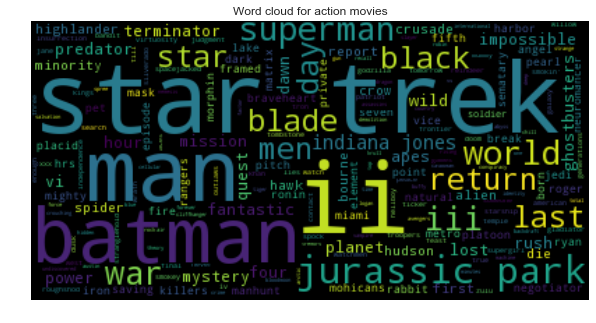

In [7]:
title_texts = " \n".join(titles[titles.genre=="action"].title.tolist())
wordcloud = WordCloud().generate(title_texts)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud for action movies")
plt.show()

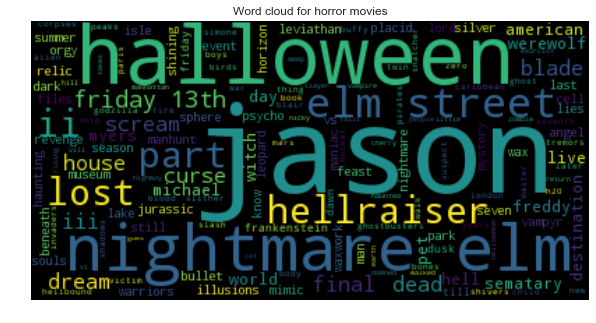

In [8]:
title_texts = " \n".join(titles[titles.genre=="horror"].title.tolist())
wordcloud = WordCloud().generate(title_texts)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud for horror movies")
plt.show()

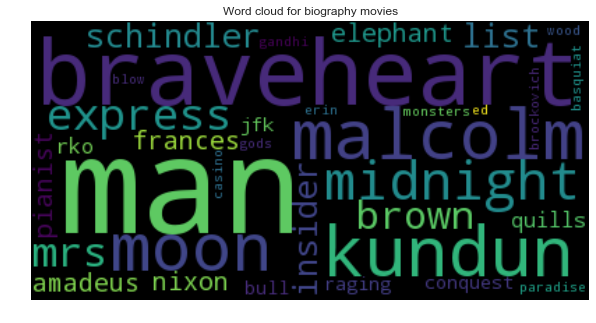

In [9]:
title_texts = " \n".join(titles[titles.genre=="biography"].title.tolist())
wordcloud = WordCloud().generate(title_texts)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud for biography movies")
plt.show()

In [10]:
lines = pd.read_json("dataset"+os.sep+"movie_lines.json")

In [11]:
lines.head(2)

,character_id,character_name,line_id,movie_id,text
0,u0,BIANCA,L1045,m0,They do not!
1,u2,CAMERON,L1044,m0,They do to!


In [12]:
lines_genre = pd.merge(lines,titles,on="movie_id",how="inner").drop_duplicates(subset=["line_id","movie_id"])

In [13]:
movie_lines = " \n".join(lines.text.tolist())

In [14]:
movie_lines_parsed = nlp(movie_lines)

In [15]:
token_text = [token.orth_ for token in movie_lines_parsed]
token_pos = [token.pos_ for token in movie_lines_parsed]
token_lemma = [token.lemma_ for token in movie_lines_parsed]
token_shape = [token.shape_ for token in movie_lines_parsed]
token_entity_type = [token.ent_type_ for token in movie_lines_parsed]

In [16]:
tokens_df = pd.DataFrame(list(zip(token_text,token_pos,token_lemma,token_shape,token_entity_type)),
                        columns=['token_text','token_pos','token_lemma','token_shape','entity_type'])

In [17]:
tokens_df.head(10)

,token_text,token_pos,token_lemma,token_shape,entity_type
0,They,PRON,-PRON-,Xxxx,
1,do,VERB,do,xx,
2,not,ADV,not,xxx,
3,!,PUNCT,!,!,
4,\n,SPACE,\n,\n,
5,They,PRON,-PRON-,Xxxx,
6,do,VERB,do,xx,
7,to,PART,to,xx,
8,!,PUNCT,!,!,
9,\n,SPACE,\n,\n,


In [18]:
tokens_df[tokens_df.entity_type!=""].tail(10)

,token_text,token_pos,token_lemma,token_shape,entity_type
4574452,the,DET,the,xxx,TIME
4574453,next,ADJ,next,xxxx,TIME
4574454,morning,NOUN,morning,xxxx,TIME
4574463,A,DET,a,X,DATE
4574464,week,NOUN,week,xxxx,DATE
4574465,later,ADV,later,xxxx,DATE
4574528,Captain,PROPN,captain,Xxxxx,ORG
4574540,one,NUM,one,xxx,CARDINAL
4574583,that,DET,that,xxxx,DATE
4574584,day,NOUN,day,xxx,DATE


In [19]:
token_attributes = [(token.orth_,
                     token.prob,
                     token.is_stop,
                     token.is_punct,
                     token.is_space,
                     token.like_num,
                     token.is_oov)
                    for token in movie_lines_parsed]
df = pd.DataFrame(token_attributes,
                  columns=['text',
                           'log_probability',
                           'stop?',
                           'punctuation?',
                           'whitespace?',
                           'number?',
                           'out of vocab.?'])

In [20]:
df.head(10)

,text,log_probability,stop?,punctuation?,whitespace?,number?,out of vocab.?
0,They,-6.996389,True,False,False,False,False
1,do,-5.300070,True,False,False,False,False
2,not,-5.219238,True,False,False,False,False
3,!,-5.515826,False,True,False,False,False
4,\n,-6.179879,False,False,True,False,False
5,They,-6.996389,True,False,False,False,False
6,do,-5.300070,True,False,False,False,False
7,to,-3.838520,True,False,False,False,False
8,!,-5.515826,False,True,False,False,False
9,\n,-6.179879,False,False,True,False,False


In [21]:
cond = ((df["stop?"]==False) & (df["punctuation?"]==False) &
        (df["whitespace?"]==False) & (df["number?"]==False) &
        (df["out of vocab.?"]==False))

In [22]:
df.shape,df[cond].shape

((4574661, 7), (1412467, 7))

In [23]:
df[cond].tail(3)

,text,log_probability,stop?,punctuation?,whitespace?,number?,out of vocab.?
4574655,include,-9.789975,False,False,False,False,False
4574656,spying,-19.579313,False,False,False,False,False
4574659,cultures,-11.163581,False,False,False,False,False


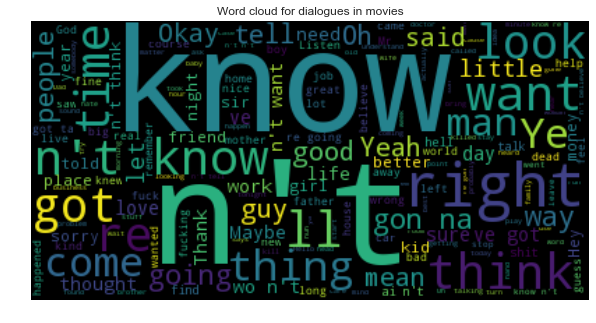

In [24]:
words = " \n".join(df[cond]["text"].tolist())
wordcloud = WordCloud().generate(words)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud for dialogues in movies")
plt.show()

<h4> Phrase modelling using Gensim <h4>

In [105]:
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
import itertools as it

In [106]:
def punct_space_stop(token):
    """
    helper functions that eliminate tokens 
    that are punctuations, whitespaces or stopwords
    """
    return token.is_punct or token.is_space or token.is_stop

In [107]:
lines = pd.read_json("dataset"+os.sep+"movie_lines.json")

In [108]:
lines.head(3)

,character_id,character_name,line_id,movie_id,text
0,u0,BIANCA,L1045,m0,They do not!
1,u2,CAMERON,L1044,m0,They do to!
10,u2,CAMERON,L868,m0,"The ""real you""."


In [109]:
lines.tail()

,character_id,character_name,line_id,movie_id,text
99995,u2980,PICARD,L536606,m195,I understand how you feel. We just want to ret...
99996,u2971,ANIJ,L536549,m195,"Capability, yes. But where can warp drive take..."
99997,u2980,PICARD,L536548,m195,You have warp capability?
99998,u2980,PICARD,L536543,m195,"If I were in your shoes, I'd feel the same way..."
99999,u2971,ANIJ,L536542,m195,Your directive apparently doesn't include spyi...


In [110]:
with open("dataset"+os.sep+"unigram_sentence_all.txt","w+",encoding='utf_8') as f:
    for sentence in movie_lines_parsed.sents:
        line = ' '.join([token.lemma_ for token in sentence
        if not punct_space_stop(token)])
        f.write(line)
        f.write("\n")

In [111]:
unigram_sentences_filepath = os.path.join("dataset","unigram_sentence_all.txt")

In [112]:
unigram_sentences = LineSentence(unigram_sentences_filepath)

In [113]:
for unigram_sentence in it.islice(unigram_sentences, 230, 240):
    print(u' '.join(unigram_sentence))
    print(u'')

dougherty

understood

right

hour captain

want briar patch

meantime will head perimeter son'a reinforcement case fail

sir commander worf work tactical plan safely

wish good news

commander data attack mission scout ship yesterday ru'afo decide send assault team

important enterprise sideline admiral



In [114]:
bigram_model_filepath = os.path.join("models","bigram_model_all")
bigram_model = Phrases(unigram_sentences)
bigram_model.save(bigram_model_filepath)
bigram_model = Phrases.load(bigram_model_filepath)

In [115]:
bigram_sentences_filepath = os.path.join("dataset","bigram_sentences_all.txt")

In [116]:
with open(bigram_sentences_filepath,"w+",encoding="utf-8") as f:
    for unigram_sentence in unigram_sentences:
        bigram_sentence = u' '.join(bigram_model[unigram_sentence])
        f.write(bigram_sentence + "\n")

C:\Users\cbgk\Anaconda3\lib\site-packages\gensim\models\phrases.py:274: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [117]:
bigram_sentences = LineSentence(bigram_sentences_filepath)

Note: words like dr crusher has been combined to dr_crusher to denote a single concept

In [118]:
for bigram_sentence in it.islice(bigram_sentences, 500, 600):
    print(u' '.join(bigram_sentence))
    print(u'')

mister_worf job find plan safely capture data

wanna work

have download file duck blind mission intelligence report son'a

better chef whip light balsamic vinaigrette go chrysanthemum

oh_god vegetarian

be

yew cheen chef faw emphasis cheen faw greeting

population million

notice boob start firm

hand battle station

kiss beard

augh

will come big thing

augh

ship happen

usually

ne not doctor_crusher

counselor think be possible people time fix mistake have

doctor_crusher will care

be sleep believe

think be have mid life crisis

be mood today

try lie

not try sit

app kind blow water

be comfortable

not usual therapeutic posture

make comfortable get minute ne little counseling

time

lie

come

hi

be true be die race

child

say form genetic damage apparently prevent son'a procreate

neck

be neck

weird short line

haven't long_time good question

involve people

be luck say have take woman race indentured servant

hmm feel right home nomadic collector precious metal jew

In [119]:
trigram_model_filepath = os.path.join("models","trigram_model_all")

In [120]:
trigram_model = Phrases(bigram_sentences)
trigram_model.save(trigram_model_filepath)
trigram_model = Phrases.load(trigram_model_filepath)

In [121]:
trigram_sentences_filepath = os.path.join("dataset","trigram_sentences_all.txt")

In [122]:
with open(trigram_sentences_filepath,"w+",encoding="utf-8") as f:
    for bigram_sentence in bigram_sentences:
        trigram_sentence = u' '.join(trigram_model[bigram_sentence])
        f.write(trigram_sentence+"\n")

C:\Users\cbgk\Anaconda3\lib\site-packages\gensim\models\phrases.py:274: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [123]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

In [124]:
for trigram_sentence in it.islice(trigram_sentences, 230, 240):
    print(u' '.join(trigram_sentence))
    print(u'')

dougherty

understood

right

hour captain

want briar patch

meantime will head perimeter son'a reinforcement case fail

sir commander worf work tactical plan safely

wish good_news

commander data attack mission scout ship yesterday ru'afo decide send assault team

important enterprise sideline admiral



In [125]:
trigram_lines_filepath = os.path.join("dataset","trigram_transformed_lines.txt")

In [126]:
def parse_line(filename):
    """
    Function to read a single line from the 
    text file and yield it
    """
    with open(filename,encoding='utf-8') as f:
        for line in f:
            yield line

In [140]:
with open(trigram_lines_filepath,"w+",encoding='utf-8') as f:
    for sent in trigram_sentences:
        line = [token for token in sent
                if token not in spacy.en.STOP_WORDS]
        line = u' '.join(line)
        f.write(line+"\n")                

<h3> Topic Modelling with LDA

In [169]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import warnings
import pickle

In [143]:
trigram_dictionary_filepath = os.path.join("dataset","trigram_dict_all.dict")

In [144]:
trigram_lines = LineSentence(trigram_lines_filepath)
trigram_dictionary = Dictionary(trigram_lines)

In [145]:
trigram_dictionary.filter_extremes(no_below=10,no_above=0.4)
trigram_dictionary.compactify()

In [146]:
trigram_dictionary.save(trigram_dictionary_filepath)

In [147]:
trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)

In [148]:
trigram_bow_filepath = os.path.join("dataset","trigram_bow_corpus_all.mm")

In [151]:
def trigram_bow_generator(filepath):
    for line in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(line)

In [152]:
MmCorpus.serialize(trigram_bow_filepath,trigram_bow_generator(trigram_lines_filepath))

In [153]:
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)

In [154]:
lda_model_filepath = os.path.join("models","lda_model_all")

In [156]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda = LdaMulticore(trigram_bow_corpus,
                      num_topics=50,
                      id2word=trigram_dictionary,
                      workers=8)
    lda.save(lda_model_filepath)
lda = LdaMulticore.load(lda_model_filepath)

In [162]:
def explore_topic(topic_number,topn=25):
    print("{:20} {}\n".format("term","frequency"))
    for term,frequency in lda.show_topic(topic_number,topn=25):
        print("{:20} {:.3}".format(term,round(frequency,3)))

In [165]:
explore_topic(topic_number=3)

term                 frequency

okay                 0.171
wait                 0.088
understand           0.08
ask                  0.056
worry                0.046
stand                0.043
admiral              0.017
fault                0.015
join                 0.014
attack               0.013
mess                 0.012
interesting          0.011
guard                0.011
christ               0.01
peter                0.01
like                 0.008
married              0.008
push                 0.007
issue                0.007
rat                  0.007
creature             0.006
slip                 0.006
heavy                0.006
magic                0.006
sword                0.006


In [172]:
LDAvis_data_filepath = os.path.join("dataset","ldavis_prepared.pkl")

In [168]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda,trigram_bow_corpus,trigram_dictionary)

In [178]:
with open(LDAvis_data_filepath,"wb") as f:
    pickle.dump(LDAvis_prepared,f)

In [181]:
with open(LDAvis_data_filepath,"rb") as f:
    LDAvis_prepared = pickle.load(f)    

In [182]:
pyLDAvis.display(LDAvis_prepared)